# **CNN MODEL**

In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the count matrix
counts = pd.read_csv('GSE112087_counts-matrix-EnsembIDs-GRCh37.p10(1).txt', sep='\t', index_col=0)

sample_names = counts.columns
# Create a decision column based on sample names
labels = ['SLE' if 'MON_SLE' in sample else 'Control' for sample in sample_names]

# Convert to DataFrame for easy merging
labels_df = pd.DataFrame({'Sample': sample_names, 'Label': labels})
# Transpose the counts DataFrame to match sample names with rows
counts_T = counts.T
counts_T.index.name = 'Sample'
counts_T.reset_index(inplace=True)
# Merge counts with labels
counts_with_labels = pd.merge(counts_T, labels_df, on='Sample')

# Encode labels as 0 and 1
counts_with_labels['Label'] = counts_with_labels['Label'].apply(lambda x: 1 if x == 'SLE' else 0)

# Split the data into features (X) and labels (y)
X = counts_with_labels.drop(['Sample', 'Label'], axis=1).values
y = counts_with_labels['Label'].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Reshape data for CNN input (samples, features, 1)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Prepare for cross-validation
kf = KFold(n_splits=3, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Collect history for each fold
train_acc_histories = []
val_acc_histories = []
train_loss_histories = []
val_loss_histories = []

input_shape = (X.shape[1], 1)

for train_index, test_index in kf.split(X):
    print(f'Training fold {fold_no} ...')

    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Define the CNN model
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=128, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train, y_train, epochs=3, batch_size=32, validation_data=(X_test, y_test))

    train_acc_histories.append(history.history['accuracy'])
    val_acc_histories.append(history.history['val_accuracy'])
    train_loss_histories.append(history.history['loss'])
    val_loss_histories.append(history.history['val_loss'])

    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

    # Clear the session to free up memory
    tf.keras.backend.clear_session()

# Calculate average accuracy and loss for each epoch across all folds
avg_train_acc = np.mean(train_acc_histories, axis=0)
avg_val_acc = np.mean(val_acc_histories, axis=0)
avg_train_loss = np.mean(train_loss_histories, axis=0)
avg_val_loss = np.mean(val_loss_histories, axis=0)

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot average accuracy
axs[0].plot(avg_train_acc, label='train_accuracy')
axs[0].plot(avg_val_acc, label='val_accuracy')
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(loc='upper left')

# Plot average loss
axs[1].plot(avg_train_loss, label='train_loss')
axs[1].plot(avg_val_loss, label='val_loss')
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(loc='upper left')

plt.show()

# Print cross-validation results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')




Training fold 1 ...
Epoch 1/3
3/3 [==============================] - 40s 12s/step - loss: 43.3567 - accuracy: 0.4375 - val_loss: 79.1681 - val_accuracy: 0.4500
Epoch 2/3
3/3 [==============================] - 37s 12s/step - loss: 49.1520 - accuracy: 0.4875 - val_loss: 27.4208 - val_accuracy: 0.5500
Epoch 3/3


KeyboardInterrupt: 

**PERCEPTRON TEST  TO SEE IF ITS BETTER**

Training fold 1 ...
Epoch 1/5
4/4 [==============================] - 3s 575ms/step - loss: 2.9520 - accuracy: 0.6204 - val_loss: 1.3135e-04 - val_accuracy: 1.0000
Epoch 2/5
4/4 [==============================] - 2s 509ms/step - loss: 0.9490 - accuracy: 0.9537 - val_loss: 4.0691 - val_accuracy: 0.8333
Epoch 3/5
4/4 [==============================] - 2s 342ms/step - loss: 0.2590 - accuracy: 0.9722 - val_loss: 1.5957 - val_accuracy: 0.8333
Epoch 4/5
4/4 [==============================] - 1s 314ms/step - loss: 0.1421 - accuracy: 0.9907 - val_loss: 4.7274 - val_accuracy: 0.8333
Epoch 5/5
4/4 [==============================] - 1s 304ms/step - loss: 1.8157e-05 - accuracy: 1.0000 - val_loss: 8.3132 - val_accuracy: 0.8333
Score for fold 1: loss of 8.313194274902344; accuracy of 83.33333134651184%
Training fold 2 ...
Epoch 1/5
4/4 [==============================] - 2s 388ms/step - loss: 1.0354 - accuracy: 0.6759 - val_loss: 1.7518 - val_accuracy: 0.6667
Epoch 2/5
4/4 [===========================

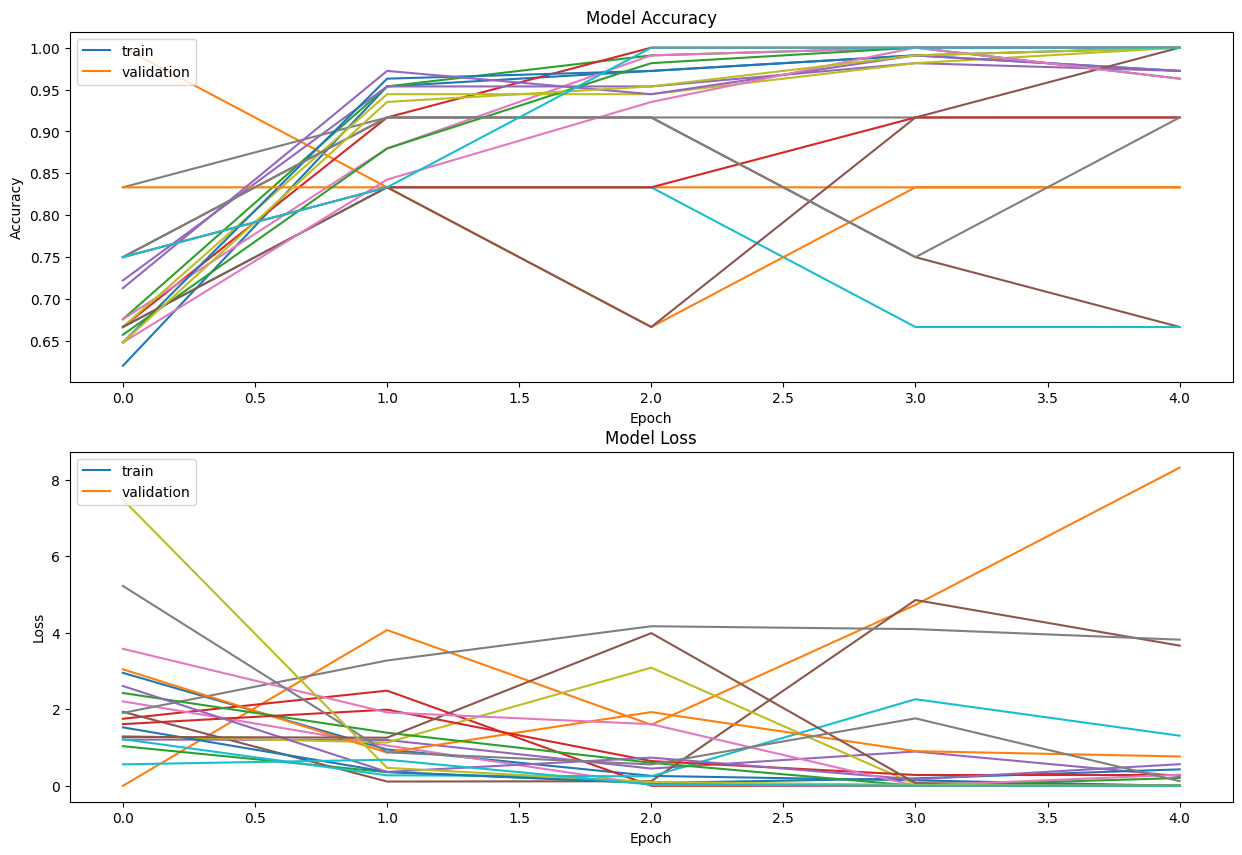

------------------------------------------------------------------------
Score per fold
> Fold 1 - Loss: 8.313194274902344 - Accuracy: 83.33333134651184%
> Fold 2 - Loss: 5.0519491196610034e-05 - Accuracy: 100.0%
> Fold 3 - Loss: 3.662416696548462 - Accuracy: 66.66666865348816%
> Fold 4 - Loss: 3.817488431930542 - Accuracy: 91.66666865348816%
> Fold 5 - Loss: 1.3088504076004028 - Accuracy: 66.66666865348816%
> Fold 6 - Loss: 0.7664377093315125 - Accuracy: 83.33333134651184%
> Fold 7 - Loss: 0.2819884121417999 - Accuracy: 91.66666865348816%
> Fold 8 - Loss: 4.6448869397863746e-05 - Accuracy: 100.0%
> Fold 9 - Loss: 0.12100718170404434 - Accuracy: 91.66666865348816%
> Fold 10 - Loss: 0.0007484051748178899 - Accuracy: 100.0%
------------------------------------------------------------------------
Average scores for all folds:
> Accuracy: 87.50000059604645 (+- 11.93151720581631)
> Loss: 1.827222848769452
------------------------------------------------------------------------


In [ ]:
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the count matrix
counts = pd.read_csv('GSE112087_counts-matrix-EnsembIDs-GRCh37.p10(1).txt', sep='\t', index_col=0)

sample_names = counts.columns
# Create a decision column based on sample names
labels = ['SLE' if 'MON_SLE' in sample else 'Control' for sample in sample_names]

# Convert to DataFrame for easy merging
labels_df = pd.DataFrame({'Sample': sample_names, 'Label': labels})
# Transpose the counts DataFrame to match sample names with rows
counts_T = counts.T
counts_T.index.name = 'Sample'
counts_T.reset_index(inplace=True)
# Merge counts with labels
counts_with_labels = pd.merge(counts_T, labels_df, on='Sample')

# Encode labels as 0 and 1
counts_with_labels['Label'] = counts_with_labels['Label'].apply(lambda x: 1 if x == 'SLE' else 0)

# Split the data into features (X) and labels (y)
X = counts_with_labels.drop(['Sample', 'Label'], axis=1).values
y = counts_with_labels['Label'].values

# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Flatten the input for perceptron (fully connected layers)
X_flat = X.reshape(X.shape[0], -1)

# Convert labels to categorical (one-hot encoding)
y_cat = to_categorical(y)

# Prepare for cross-validation
kf = KFold(n_splits=10, shuffle=True, random_state=42)
fold_no = 1
acc_per_fold = []
loss_per_fold = []

# Collect history for each fold
histories = []

input_length = X_flat.shape[1]

for train_index, test_index in kf.split(X_flat):
    print(f'Training fold {fold_no} ...')

    X_train, X_test = X_flat[train_index], X_flat[test_index]
    y_train, y_test = y_cat[train_index], y_cat[test_index]

    # Define the Perceptron model with smaller layer sizes
    model = Sequential()
    model.add(Dense(256, activation='relu', input_shape=(input_length,)))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    history = model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))
    histories.append(history)

    scores = model.evaluate(X_test, y_test, verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    fold_no += 1

    # Clear the session to free up memory
    tf.keras.backend.clear_session()

# Plot the results
fig, axs = plt.subplots(2, 1, figsize=(15, 10))

# Plot accuracy
for history in histories:
    axs[0].plot(history.history['accuracy'])
    axs[0].plot(history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'validation'], loc='upper left')

# Plot loss
for history in histories:
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'validation'], loc='upper left')

plt.show()

# Print cross-validation results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

